# import

In [1]:
import os
import math
from pathlib import Path
# import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import copy
from qutip import *
from qutip.fileio import *
from qutip.interpolate import *
# import qutip.ipynbtools as qpipy
from qutip.qip.operations import cphase as CPhase
from qutip.qip.operations import rz
from scipy.fft import fft, fftfreq
from scipy.special import erf
from scipy.interpolate import interp1d
from scipy import signal
from scipy.integrate import odeint
from scipy import linalg
from scipy.optimize import minimize, minimize_scalar
import scipy.constants as cn
import random
import cmath
import itertools
from cycler import cycler
# from pynverse import inversefunc
from IPython.display import display, Math
import warnings

In [5]:
# 可交互图像
%matplotlib notebook

# 初始化

## 参数

In [2]:
device_paras={'w': 5, \
              'alpha': -200}

## 希尔伯特空间

In [3]:
Nstates = 3
#升降算符
a = destroy(Nstates)
ad = create(Nstates)
I = qeye(Nstates)

#单比特初始裸态
ground = basis(Nstates, 0)
excited = basis(Nstates, 1)
leakage = basis(Nstates, 2)
sx1 = a + ad
sy1 = 1j * (ad - a)
sz1 = I - 2 * ad * a

## 系统哈密顿量

In [4]:
def Hamiltonian(device_paras):
    w = device_paras['w'] * 2.0 * np.pi

    alpha = device_paras['alpha'] * 10**(-3) * 2.0 * np.pi

    H0 = w * ad * a + alpha / 2.0 * ad * ad * a * a

    return H0

## 本征态

In [5]:
#定义基本的能级顺序
energy_info = {'dim': [3], 'exci_num': 4, 'bas_list': [], 'bas_name_list': []}

for bas in state_number_enumerate(energy_info['dim'],
                                  excitations=energy_info['exci_num']):
    energy_info['bas_list'].append(state_number_qobj(energy_info['dim'], bas))
    energy_info['bas_name_list'].append(''.join(map(str, bas)))
energy_info['bas_num'] = len(energy_info['bas_list'])

print(energy_info['bas_name_list'])

['0', '1', '2']


# 单比特门

## 驱动脉冲

In [74]:
def drive_pulseX1(t, args):
    t_g = args['gate time']
    amp = args['q1 amp']
    cross = args['cross']
    w_d = args['q1 drive frequency'] * 2 * np.pi
    w_c = args['q1 cross frequency'] * 2 * np.pi
    alpha = device_paras['alpha'] * 2 * np.pi * 10**(-3)
    detune = args['q1 detune'] * 2 * np.pi * 10**(-3)
    lambda1 = 0.5
    phi = args['q1 phi'] * 2 * np.pi * 10**(-3)
    I = np.cos(phi)
    Q = np.sin(phi)
    X0 = amp * (1 - np.cos(2 * np.pi * t / tg)) / 2
    Y0 = -amp * np.pi / tg * np.sin(2 * np.pi * t / tg) / alpha * lambda1
    X = (X0 * I + Y0 * Q) * np.cos(
        (w_d + detune) * t) + cross *0.15/amp * (X0 * I + Y0 * Q) * np.cos(
            (w_c + detune) * t)
    return X


def drive_pulseY1(t, args):
    t_g = args['gate time']
    amp = args['q1 amp']
    cross = args['cross']
    w_d = args['q1 drive frequency'] * 2 * np.pi
    w_c = args['q1 cross frequency'] * 2 * np.pi
    alpha = device_paras['alpha'] * 2 * np.pi * 10**(-3)
    detune = args['q1 detune'] * 2 * np.pi * 10**(-3)
    lambda1 = 0.5
    phi = args['q1 phi'] * 2 * np.pi * 10**(-3)
    I = np.cos(phi)
    Q = np.sin(phi)
    X0 = amp * (1 - np.cos(2 * np.pi * t / tg)) / 2
    Y0 = -amp * np.pi / tg * np.sin(2 * np.pi * t / tg) / alpha * lambda1
    Y = (Y0 * I - X0 * Q) * np.cos(
        (w_d + detune) * t) + cross*0.15/amp* (Y0 * I - X0 * Q) * np.cos(
            (w_c + detune) * t )
    return Y

## 单比特QPT

In [7]:
rho0 = fock_dm(3, 0)
rho1 = fock_dm(3, 1)
rho2 = ket2dm((basis(3, 0) + basis(3, 1)) / np.sqrt(2))
rho3 = ket2dm((basis(3, 0) + 1j * basis(3, 1)) / np.sqrt(2))

rho_in = [rho0, rho1, rho2, rho3]

rho0_ = fock_dm(2, 0)
rho1_ = fock_dm(2, 1)
rho2_ = ket2dm((basis(2, 0) + basis(2, 1)) / np.sqrt(2))
rho3_ = ket2dm((basis(2, 0) + 1j * basis(2, 1)) / np.sqrt(2))
rho_basis = [rho0_, rho1_, rho2_, rho3_]

op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]]
U_rho = spre(sigmax()) * spost(sigmax().dag())
chi_ideal = qpt(U_rho, op_basis)


def qpt1(U):

    rho_out = [(U * rho_in[i] * U.dag())[[0, 1], :][:, [0, 1]]
               for i in range(len(rho_in))]
    rho_basis_mat = np.hstack([mat2vec(rho.full()) for rho in rho_basis])

    rho_out_mat = np.hstack([mat2vec(rho) for rho in rho_out])
    Gamma = linalg.solve(rho_basis_mat.T, rho_out_mat.T)
    Gamma = Gamma.T
    vecGamma = mat2vec(Gamma)

    op_basis = [qeye(2), sigmax(), sigmay(), sigmaz()]
    EE_ops = [sprepost(E1, E2.dag()) for E1 in op_basis for E2 in op_basis]
    Beta = np.hstack([mat2vec(EE.full()) for EE in EE_ops])
    vecChi = linalg.solve(Beta, vecGamma)
    Chi = vec2mat(vecChi)
    error = 1 - np.trace(np.dot(chi_ideal, Chi))
    return error

In [12]:
rho_basis

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[1. 0.]
  [0. 0.]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0. 0.]
  [0. 1.]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.5 0.5]
  [0.5 0.5]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.5+0.j  0. -0.5j]
  [0. +0.5j 0.5+0.j ]]]

In [11]:
rho_out=[(U * rho_in[i]*U.dag())[[0,1],:][:,[0,1]] for i in range(len(rho_in))]
rho_basis_mat = np.hstack([mat2vec(rho.full()) for rho in rho_basis])


rho_out_mat = np.hstack([mat2vec(rho) for rho in rho_out])
Gamma = linalg.solve(rho_basis_mat.T, rho_out_mat.T)
Gamma = Gamma.T
vecGamma = mat2vec(Gamma)

NameError: name 'U' is not defined

## 保真度计算

In [13]:
def Fidelity_X(U_full):
    U = Qobj(U_full[[0,1],:][:,[0,1]])
    f = lambda phi :  1-abs(np.trace(np.dot((rz(phi)*U).dag(),(rz(phi)*U)))+(abs(np.trace(np.dot(sigmax().dag(),(rz(phi)*U))))** 2))/6
    res = minimize_scalar(f, method='brent')
    return res.fun

## 哈密顿量演化

In [86]:
tg = 40
t_list = np.linspace(0, tg, 300)


def Evolution_q1(pulse_paras, H, u, w2):

    H_x1 = [sx1, drive_pulseX1]
    H_y1 = [sy1, drive_pulseY1]
    Ht = [H, H_x1, H_y1]

    args1['q1 amp'] = pulse_paras[1]
    args1['q1 detune'] = pulse_paras[0]
    args1['q1 phi'] = -pulse_paras[0] * tg / 2
    args1['q1 cross frequency'] = w2
    args1['cross'] = u

    U_full = propagator(Ht, t_list, args=args1)[-1]

    error = abs(qpt1(U_full))

    return error

## 并行计算串扰

In [87]:

global args1
args1 = {}  
args1['gate time'] = tg
args1['q1 drive frequency'] = device_paras['w']
args1['drag weight']=0.5

H = Hamiltonian(device_paras)

x0 = [0,0.15]
bounds = ((x0[0]-10,x0[0]+10),(x0[1]-0.07,x0[1]+0.07) )
start = time.time();count=0;error_list = [];
result1 = minimize(Evolution_q1, x0 ,args=(H,0,0,),bounds=bounds, method='SLSQP',options={'ftol': 1e-06})


def par_cross(parameter):
    u = parameter[0]
    w2 = parameter[1]+5
    error = Evolution_q1(result1.x,H,u,w2)
    
    return error
    
    
    

In [88]:
result1

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.6563720173223828e-07
       x: [-6.632e-05  1.573e-01]
     nit: 3
     jac: [ 1.987e-05 -4.246e-04]
    nfev: 10
    njev: 3

In [83]:
parameter=[]
delta_list=np.linspace(-0.5,0,51)
u_list=np.linspace(0,0.5,51)

for u in u_list:
    for delta in delta_list:
        parameter.append([u,delta])

In [21]:
par_cross([0.5,0.2])

0.00012546775706956392

In [89]:
error_cross_list = parallel_map(par_cross, parameter, progress_bar=True,num_cpus=24)  

10.0%. Run time:   6.82s. Est. time left: 00:00:01:01
20.0%. Run time:  13.29s. Est. time left: 00:00:00:53
30.0%. Run time:  19.75s. Est. time left: 00:00:00:46
40.0%. Run time:  26.21s. Est. time left: 00:00:00:39
50.0%. Run time:  32.65s. Est. time left: 00:00:00:32
60.0%. Run time:  39.08s. Est. time left: 00:00:00:26
70.0%. Run time:  45.47s. Est. time left: 00:00:00:19
80.0%. Run time:  51.78s. Est. time left: 00:00:00:12
90.0%. Run time:  58.20s. Est. time left: 00:00:00:06
100.0%. Run time:  64.65s. Est. time left: 00:00:00:00
Total run time:  64.69s


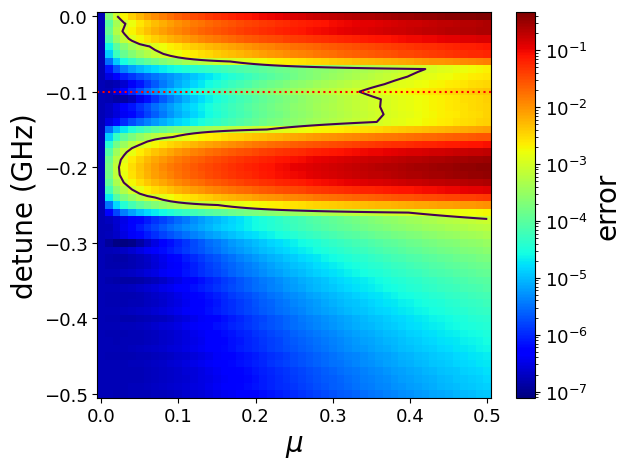

In [91]:
%matplotlib inline

error_list = error_cross_list
error_arr = np.array(error_list).reshape(len(u_list),len(delta_list))

#plot
xx,yy = np.meshgrid(u_list,delta_list)

font2 = {'weight' : 'normal','size' : 20}
fig, ax = plt.subplots()
norm = mpl.colors.LogNorm()
c = ax.pcolormesh(xx,yy,error_arr.T,cmap='jet', norm=norm)

cb=plt.colorbar(c, ax=ax, norm=norm)
ax.contour(xx,yy,error_arr.T,[1e-3])



ax.axhline(-0.1, linestyle=':', color='red', label='threshold') 
# plt.plot(u_list,np.linspace(-0.2,-0.2,len(u_list)),linewidth=3,color='blue')
# plt.plot(u_list,np.linspace(-0.11,-0.11,len(u_list)),linewidth=3,color='r')
# plt.plot(u_list,np.linspace(-0.3,-0.3,len(u_list)),linewidth=3,color='r')
cb.set_label('error',fontdict=font2) 
cb.ax.tick_params(labelsize=13)
plt.xlabel('$\mu$',font2)
plt.ylabel('detune (GHz)',font2)
plt.tick_params(labelsize=13)

labels = ax.get_xticklabels() + ax.get_yticklabels()
# [label.set_fontname('Times New Roman') for label in labels]
plt.tight_layout()
plt.savefig('./图片/固定bias_amp040ns.png', dpi=600)

## ACstark效应

## 并行单比特门计算

In [84]:
def par_X1(device_paras):

    
    global args1
    args1 = {}  
    args1['gate time'] = tg
    args1['q1 drive frequency'] = device_paras['w']
    args1['drag weight']=0.5
    
    H0,H = Hamiltonian(device_paras)
    states, states0, energy, energy0 =eigensolve(H0,H)

    

    
    
    #校准Q1，校准时Q2置0
    detune_0=(energy[state_number_index(energy_info['dim'], [1, 0])]-\
            energy[state_number_index(energy_info['dim'], [0, 0])]-\
            energy0[state_number_index(energy_info['dim'], [1,0])]+\
            energy0[state_number_index(energy_info['dim'], [0, 0])])/(2*np.pi*10**(-3))
    x0 = [detune_0,0.21]
    bounds = ((x0[0]-10,x0[0]+10),(x0[1]-0.07,x0[1]+0.07) )
    start = time.time();count=0;error_list = [];
    result1 = minimize(Evolution_q1, x0 ,args=(H,states,0,),bounds=bounds, method='SLSQP',options={'ftol': 1e-06})
    
    #Q2置1,演化Q1
    
    error = Evolution_q1(result1.x,H,states,1)

    

    return result1.fun, error


In [93]:
global args1
args1 = {}  
args1['gate time'] = tg
args1['q1 drive frequency'] = device_paras['w'][0]
args1['drag weight']=0.5

H0,H = Hamiltonian(device_paras)
states, states0, energy, energy0 =eigensolve(H0,H)





#校准Q1，校准时Q2置0
detune_0=(energy[state_number_index(energy_info['dim'], [1, 0])]-\
        energy[state_number_index(energy_info['dim'], [0, 0])]-\
        energy0[state_number_index(energy_info['dim'], [1,0])]+\
        energy0[state_number_index(energy_info['dim'], [0, 0])])/(2*np.pi*10**(-3))
x0 = [detune_0,0.21]
bounds = ((x0[0]-10,x0[0]+10),(x0[1]-0.07,x0[1]+0.07) )
start = time.time();count=0;error_list = [];
result1 = minimize(Evolution_q1, x0 ,args=(H,states,0,),bounds=bounds, method='SLSQP',options={'ftol': 1e-06})

detune_list = np.linspace(-2,2,40)
error_list = []
for detune in detune_list:
    error = Evolution_q1([result1.x[0]+detune,result1.x[1]],H,states,0)
    error_list.append(error)
    print(len(error_list))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


<IPython.core.display.Javascript object>


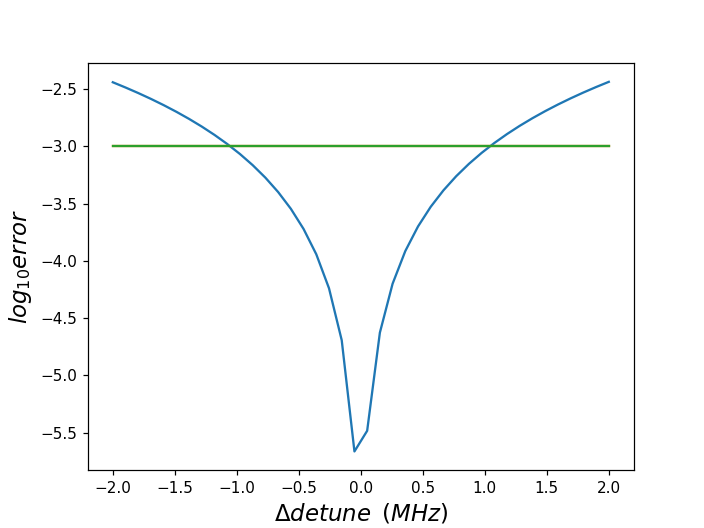

Text(0, 0.5, '$log_{10}error$')

In [102]:
%matplotlib notebook
plt.plot(detune_list,[math.log(error,10) for error in error_list])
plt.plot(detune_list,[-3 for i in detune_list])
plt.plot(detune_list,[-3 for i in detune_list])
font2 = {'family' : 'Times New Roman','weight' : 'normal','size' : 15}
plt.xlabel('$\Delta detune\enspace(MHz)$',font2)
plt.ylabel('$log_{10}error$',font2)

In [85]:
parameter=[]
w2_list=np.linspace(3,7,41)
g_list=np.linspace(0.,150,51)
for g in g_list:
    for w2 in w2_list:
        device_paras['w']=np.array([5, w2])
        device_paras[s'g']=g
        parameter.append(copy.deepcopy(device_paras))
        
error= parallel_map(par_X1, parameter, progress_bar=True,num_cpus=24)     

10.0%. Run time: 119.60s. Est. time left: 00:00:17:51
20.0%. Run time: 226.81s. Est. time left: 00:00:15:05
30.0%. Run time: 339.01s. Est. time left: 00:00:13:09
40.0%. Run time: 465.33s. Est. time left: 00:00:11:37
50.0%. Run time: 604.09s. Est. time left: 00:00:10:03
60.0%. Run time: 759.25s. Est. time left: 00:00:08:25
70.0%. Run time: 934.99s. Est. time left: 00:00:06:40
80.0%. Run time: 1127.84s. Est. time left: 00:00:04:41
90.0%. Run time: 1335.76s. Est. time left: 00:00:02:28
100.0%. Run time: 1576.21s. Est. time left: 00:00:00:00
Total run time: 1576.36s
